In [2]:
import time
start_time = time.time()
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [3]:
# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

# Qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, SLSQP, AQGD
from qiskit_algorithms.utils import algorithm_globals

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.visualization import plot_histogram
from IPython.display import clear_output

# Machine learning and preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [111]:
from sklearn.datasets import load_iris
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
features = MinMaxScaler().fit_transform(features)
algorithm_globals.random_seed = 4701

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size = 0.8, random_state = algorithm_globals.random_seed)
num_features = features.shape[1]

In [7]:
labels.shape

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [15]:
features = np.delete(features,0,axis=1)

In [29]:
for i in range(4):
    print(i)

0
1
2
3


In [30]:
full_features = iris_data.data
for i in range(4): 
    features = full_features
    features = np.delete(features, i, axis = 1)
    print(features.shape)

(150, 3)
(150, 3)
(150, 3)
(150, 3)


In [92]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
labels = iris_data.target

In [77]:
features = df[df.columns[:-1]]
labels = df[df.columns[:1]]

In [26]:
optimizer=COBYLA(maxiter=100)
feature_map = ZZFeatureMap(feature_dimension=4, reps =1 )
ansatz = RealAmplitudes(num_qubits=num_features, reps = 3)

In [16]:
sampler = Sampler()

In [18]:
objective_func_vals = []

# objective function characterizes the distance between the predictions and known labeled data.

plt.rcParams['figure.figsize'] = (12,6)

def callback_graph(weights, obj_func_eval):
             
# Append the value of the objective function to an array so we 
# can plot the iteration verses the objective function value
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration- COBYLA & RealAmplitudes')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

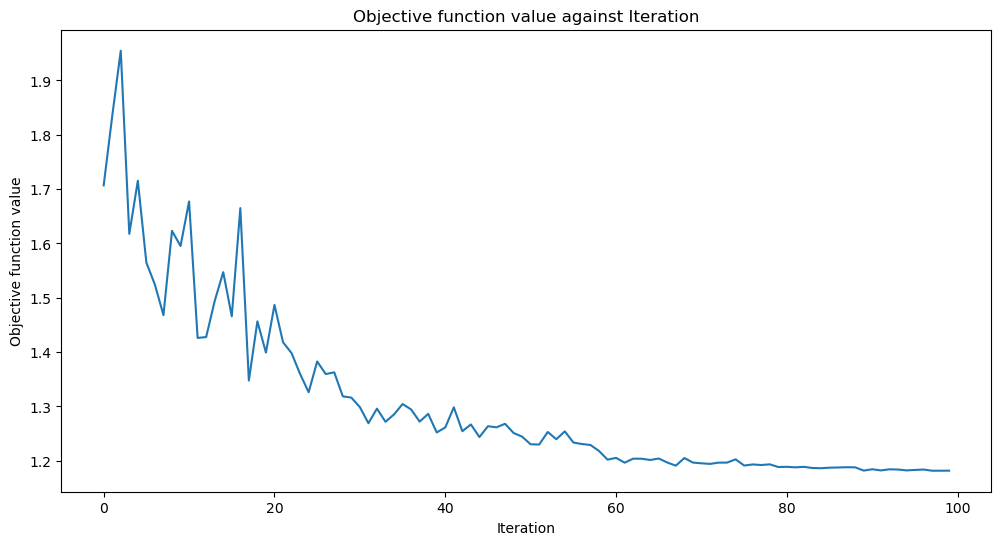

Training time: 97.22196197509766


In [19]:
vqc = VQC(
    sampler = sampler, 
    feature_map = feature_map,
    ansatz = ansatz, 
    optimizer = optimizer, 
    callback = callback_graph,)

# Clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features,train_labels)
elsapsed_time = time.time() - start 

print(f'Training time: {elsapsed_time}')

In [25]:
print(vqc.score(test_features, test_labels))

0.6333333333333333


In [28]:
optimizer=ADAM(maxiter=100)
feature_map = ZZFeatureMap(feature_dimension=4, reps =1 )
ansatz = RealAmplitudes(num_qubits=num_features, reps = 3)

In [31]:
objective_func_vals = []

# objective function characterizes the distance between the predictions and known labeled data.

plt.rcParams['figure.figsize'] = (12,6)

def callback_graph(weights, obj_func_eval):
             
# Append the value of the objective function to an array so we 
# can plot the iteration verses the objective function value
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration Adam Optimizer')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

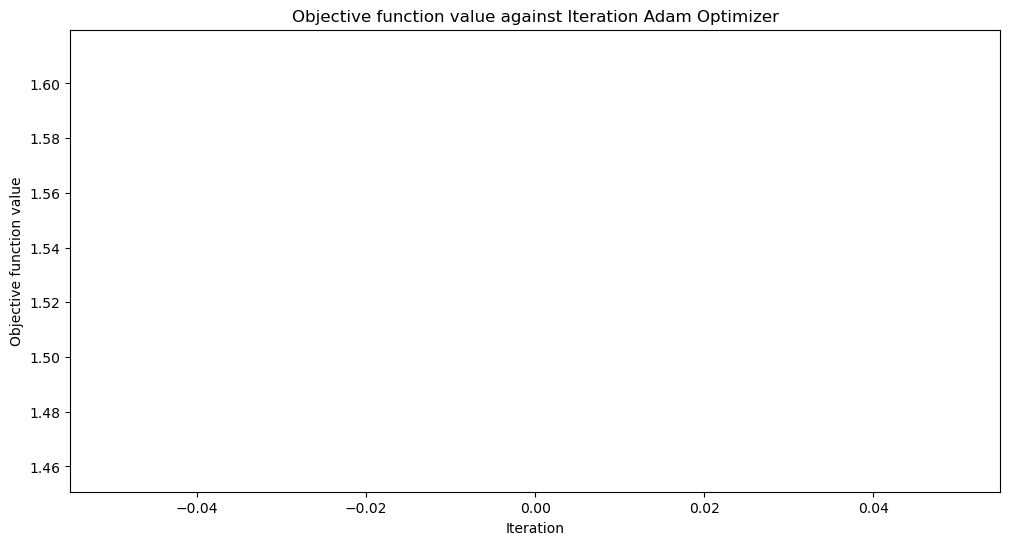

Training time: 2358.7967698574066


In [32]:
vqc = VQC(
    sampler = sampler, 
    feature_map = feature_map,
    ansatz = ansatz, 
    optimizer = optimizer, 
    callback = callback_graph,)

# Clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features,train_labels)
elsapsed_time = time.time() - start 

print(f'Training time: {elsapsed_time}')

In [33]:
print(vqc.score(test_features, test_labels))

0.5


In [36]:
optimizer=SLSQP(maxiter=100)
feature_map = ZZFeatureMap(feature_dimension=4, reps =1 )
ansatz = RealAmplitudes(num_qubits=num_features, reps = 3)

In [37]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration SLSQP Optimizer')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

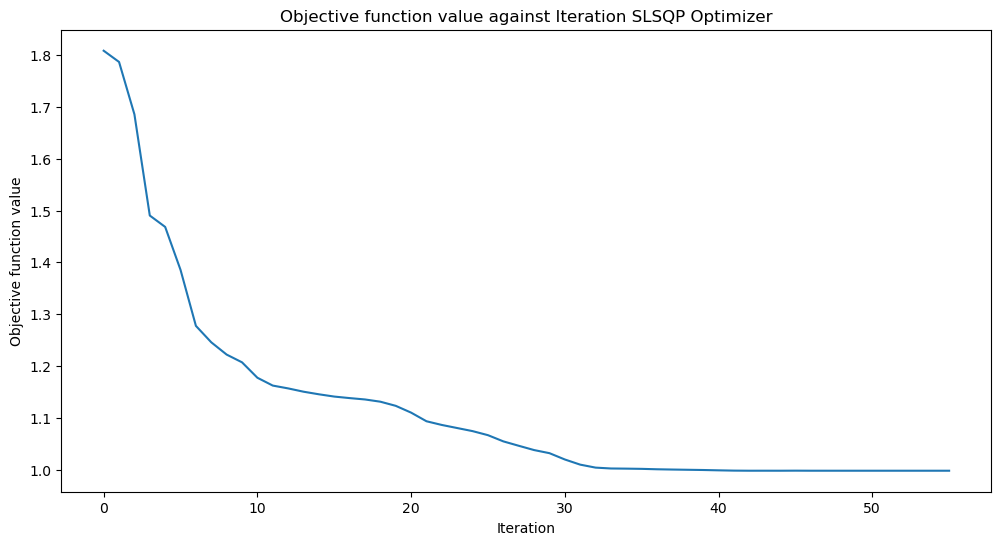

Training time: 812.7462010383606


In [38]:
vqc = VQC(
    sampler = sampler, 
    feature_map = feature_map,
    ansatz = ansatz, 
    optimizer = optimizer, 
    callback = callback_graph,)

objective_func_vals = []

start = time.time()
vqc.fit(train_features,train_labels)
elsapsed_time = time.time() - start 

print(f'Training time: {elsapsed_time}')

In [39]:
print(vqc.score(test_features, test_labels))

0.8666666666666667


In [45]:
optimizer=COBYLA(maxiter=100)
feature_map = ZZFeatureMap(feature_dimension=4, reps =1 )
ansatz = EfficientSU2(num_qubits=num_features, reps = 3)

In [46]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration EFF Ansatz')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

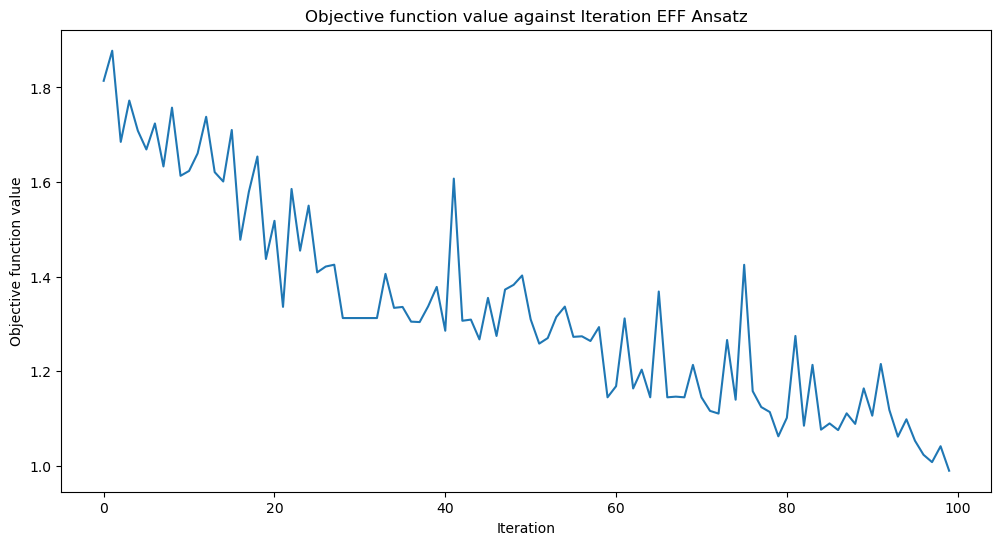

Training time: 149.12835884094238


In [47]:
vqc = VQC(
    sampler = sampler, 
    feature_map = feature_map,
    ansatz = ansatz, 
    optimizer = optimizer, 
    callback = callback_graph,)

objective_func_vals = []

start = time.time()
vqc.fit(train_features,train_labels)
elsapsed_time = time.time() - start 

print(f'Training time: {elsapsed_time}')

In [48]:
optimizer=SLSQP(maxiter=100)
feature_map = ZZFeatureMap(feature_dimension=4, reps =1 )
ansatz = EfficientSU2(num_qubits=num_features, reps = 3)

In [68]:
objective_func_vals = []
plt.rcParams['figure.figsize'] = (12,6)

def callback_graph(weights, obj_func_eval):
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration EFF Ansatz')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

In [69]:
vqc = VQC(
    sampler = sampler, 
    feature_map = feature_map,
    ansatz = ansatz, 
    optimizer = optimizer, 
    callback = callback_graph,)

objective_func_vals = []

start = time.time()
vqc.fit(train_features,train_labels)
elsapsed_time = time.time() - start 

print(f'Training time: {elsapsed_time}')

NameError: name 'sampler' is not defined

In [51]:
print(vqc.score(test_features, test_labels))

0.9


In [70]:
# Preparing DataFrames each missing one feature
dfs = {
    "Full Features": df,
    "Missing Sepal Length": df.drop(columns=['sepal length (cm)']),
    "Missing Sepal Width": df.drop(columns=['sepal width (cm)']),
    "Missing Petal Length": df.drop(columns=['petal length (cm)']),
    "Missing Petal Width": df.drop(columns=['petal width (cm)']),
}

In [101]:
optimizer=COBYLA(maxiter=100)
feature_map = ZZFeatureMap(feature_dimension=4, reps =1 )
ansatz = RealAmplitudes(num_qubits=num_features, reps = 3)

In [102]:
def callback_graph(weights, obj_func_eval):
    global current_dataset
    clear_output(wait=True)
    objective_func_vals_dict[current_dataset].append(obj_func_eval)
    plt.title("Objective function value against Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    
    for description, obj_vals in objective_func_vals_dict.items():
        if obj_vals:  # Plot only if there are values
            iterations = range(len(obj_vals))
            plt.plot(iterations, obj_vals, label=description)
            # Annotate the most recent point
            plt.annotate(f"{obj_vals[-1]:.2f}",
                         (iterations[-1], obj_vals[-1]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center',
                         fontsize=8)

    plt.legend()
    plt.show()


In [103]:
full_features = iris_data.data

In [104]:
data_descriptions = ["Full Features", "Missing Sepal Length", "Missing Sepal Width", "Missing Petal Length",
                     "Missing Petal Width"]

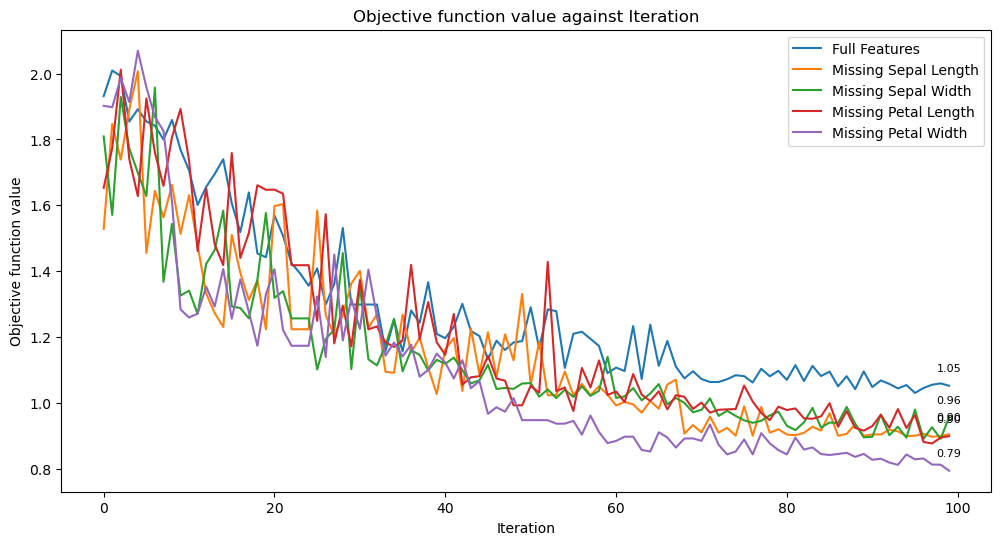

Training time: 89.07 seconds


In [106]:
training_times = {}
vqc_scores = {}
plt.clf()
objective_func_vals_dict = {
    "Full Features": [],
    "Missing Sepal Length": [],
    "Missing Sepal Width": [],
    "Missing Petal Length": [],
    "Missing Petal Width": []
}

for i, description in enumerate(data_descriptions):
    features = full_features
    if i == 0:
        features = features # Run VQC on full feature set first
    else:
        features = np.delete(features, i-1, axis = 1)
    
    num_features = features.shape[1]  # Adjusted to current feature count
    current_dataset = description
    
    # Dynamically adjust the feature map and ansatz for the current number of features
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = EfficientSU2(num_qubits=num_features, reps=3)
    
    
    # Prepare features and labels
    features_scaled = MinMaxScaler().fit_transform(features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        features_scaled, labels, train_size=0.8, random_state=algorithm_globals.random_seed)
    
    # Initialize VQC for the adjusted feature map and ansatz
    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph
    )
    # Measure training time
    start_time = time.time()
    vqc.fit(train_features, train_labels)
    elapsed_time = time.time() - start_time
    
    # Scores
    train_score_quantum = vqc.score(train_features, train_labels)
    test_score_quantum = vqc.score(test_features, test_labels)
    vqc_scores[description] = {'Training Score': train_score_quantum, 'Test Score': test_score_quantum}

    # Store elapsed time for training
    training_times[description] = elapsed_time
    print(f"Training time: {elapsed_time:.2f} seconds")

In [107]:
full_feature_test_score_quantum = vqc_scores['Full Features']['Test Score']
quantum_differences = {desc: full_feature_test_score_quantum - vqc_scores[desc]['Test Score'] 
                       for desc in vqc_scores if desc != "Full Features"}
descriptions_quantum = list(quantum_differences.keys())
quantum_diff_values = list(quantum_differences.values())

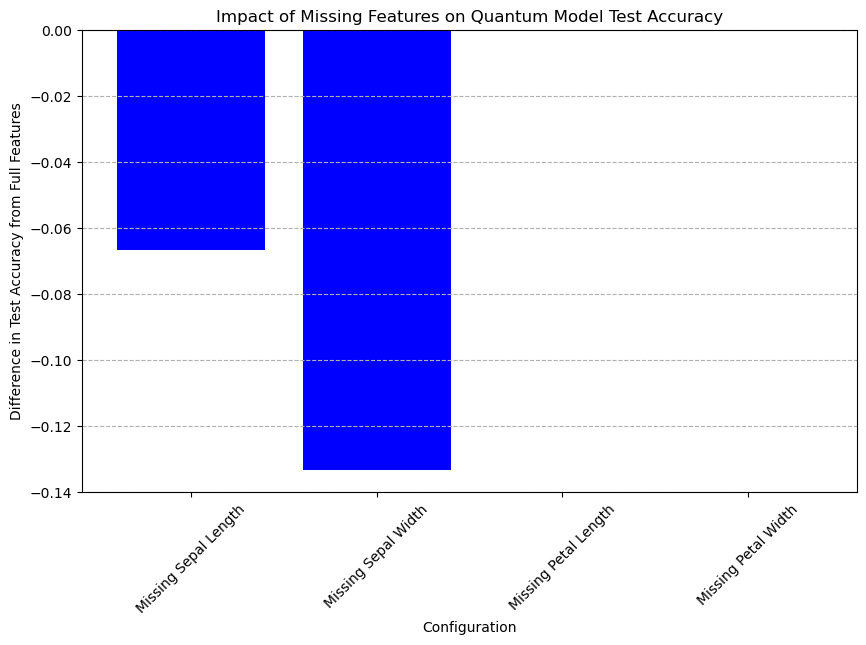

Quantum Scores and Differences from Full Features:
Full Features:
  - Quantum VQC on the training dataset: 0.83
  - Quantum VQC on the test dataset:     0.80
  - Difference from Full Features test score: 0.00

Missing Sepal Length:
  - Quantum VQC on the training dataset: 0.92
  - Quantum VQC on the test dataset:     0.87
  - Difference from Full Features test score: -0.07

Missing Sepal Width:
  - Quantum VQC on the training dataset: 0.88
  - Quantum VQC on the test dataset:     0.93
  - Difference from Full Features test score: -0.13

Missing Petal Length:
  - Quantum VQC on the training dataset: 0.85
  - Quantum VQC on the test dataset:     0.80
  - Difference from Full Features test score: 0.00

Missing Petal Width:
  - Quantum VQC on the training dataset: 0.83
  - Quantum VQC on the test dataset:     0.80
  - Difference from Full Features test score: 0.00



In [108]:
plt.figure(figsize=(10, 6))
plt.bar(descriptions_quantum, quantum_diff_values, color='blue')
plt.xlabel('Configuration')
plt.ylabel('Difference in Test Accuracy from Full Features')
plt.title('Impact of Missing Features on Quantum Model Test Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

# Print scores and differences for quantum models
print("Quantum Scores and Differences from Full Features:")
for description, scores in vqc_scores.items():
        test_score_quantum = scores['Test Score']
        difference_quantum = full_feature_test_score_quantum - test_score_quantum
        print(f"{description}:")
        print(f"  - Quantum VQC on the training dataset: {scores['Training Score']:.2f}")
        print(f"  - Quantum VQC on the test dataset:     {test_score_quantum:.2f}")
        print(f"  - Difference from Full Features test score: {difference_quantum:.2f}\n")